## Preparacion de los datos

1. Importar y cargar el conjunto de datos CIFAR-10 (disponible en keras.datasets).
2. Normalizar los datos (valores entre 0 y 1)
3. Mostrar ejemplos de imágenes con sus etiquetas.


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Cargar CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convertir a float32 y normalizar
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Mostrar algunas imágenes normalizadas
num_examples = 9
plt.figure(figsize=(6,6))
for i in range(num_examples):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])  # valores ya están entre 0 y 1
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

- Este código carga el dataset CIFAR-10, que contiene imágenes de tamaño 32×32 con 3 canales de color (RGB). Las imágenes se cargan como arreglos de enteros entre 0 y 255, que representan la intensidad de cada píxel.
- Para facilitar el entrenamiento de redes neuronales, se aplica normalización. Esto convierte los valores de los píxeles a números decimales entre 0 y 1, lo que hace que el modelo aprenda más rápido y estable, ya que evita trabajar con números grandes y mejora la convergencia del optimizador.
- Después de normalizar, se muestran algunas imágenes junto con su etiqueta en texto (ej. airplane, cat, dog). Para eso se usa matplotlib, que interpreta automáticamente los valores normalizados [0,1] como colores.

## Modelo Base ANN

1. Implementar una red neuronal totalmente conectada (ANN) como modelo de referencia:
* Flatten de la imagen (32×32×3 → 3072).
* 1–2 capas densas con activación ReLU.
* Capa de salida softmax (10 clases).
2. Entrenar el modelo y registrar: exactitud en entrenamiento/validación y tiempo de
entrenamiento.

In [2]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Crear modelo ANN
model = Sequential([
    Flatten(input_shape=(32,32,3)),       # 32x32x3 → 3072
    Dense(512, activation='relu'),        # Primera capa oculta
    Dense(256, activation='relu'),        # Segunda capa oculta (opcional)
    Dense(10, activation='softmax')       # Capa de salida para 10 clases
])

# Compilar modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Entrenar modelo y medir tiempo
start_time = time.time()
history_ann = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=64,
                    verbose=2)
end_time = time.time()

print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

# Evaluar exactitud en test
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Exactitud en test: {test_acc:.4f}")

Epoch 1/10
625/625 - 4s - 7ms/step - accuracy: 0.6858 - loss: 0.8860 - val_accuracy: 0.7228 - val_loss: 0.8088
Epoch 2/10
625/625 - 4s - 6ms/step - accuracy: 0.6915 - loss: 0.8706 - val_accuracy: 0.7135 - val_loss: 0.8341
Epoch 3/10
625/625 - 5s - 8ms/step - accuracy: 0.6954 - loss: 0.8579 - val_accuracy: 0.7195 - val_loss: 0.8316
Epoch 4/10
625/625 - 5s - 8ms/step - accuracy: 0.6969 - loss: 0.8510 - val_accuracy: 0.6951 - val_loss: 0.8939
Epoch 5/10
625/625 - 3s - 4ms/step - accuracy: 0.7028 - loss: 0.8292 - val_accuracy: 0.7232 - val_loss: 0.8101
Epoch 6/10
625/625 - 6s - 9ms/step - accuracy: 0.7036 - loss: 0.8285 - val_accuracy: 0.7247 - val_loss: 0.8023
Epoch 7/10
625/625 - 3s - 5ms/step - accuracy: 0.7082 - loss: 0.8188 - val_accuracy: 0.7228 - val_loss: 0.7990
Epoch 8/10
625/625 - 3s - 4ms/step - accuracy: 0.7156 - loss: 0.8029 - val_accuracy: 0.7241 - val_loss: 0.8050
Epoch 9/10
625/625 - 5s - 8ms/step - accuracy: 0.7192 - loss: 0.7875 - val_accuracy: 0.7329 - val_loss: 0.7857
E

Breve descripción del rendimiento:

La red neuronal totalmente conectada (ANN) logra aprender patrones básicos, pero su rendimiento se queda limitado entre 45% y 50% de exactitud, lo que es bajo comparado con modelos convolucionales. Esto ocurre porque aplanar las imágenes hace que se **pierda la información espacial** (formas, bordes, patrones locales), que es crucial en visión por computadora.
- Este sirve como modelo de referencia, pero para mejorar el rendimiento en CIFAR-10 vamos a usar redes convolucionales

## Modelo Base CNN

1. Definir un modelo CNN con los siguientes elementos mínimos:
* Capas Convolucionales (Conv2D): ≥ 2 capas con filtros (ej. 32, 64) y kernel 3×3, activación ReLU.
* Capas de Pooling (MaxPooling2D).
* Capas densas finales y softmax (10 salidas).
2. Entrenar la red y experimentar con hiperparámetros, Dropout Layers y Early Stopping.

In [4]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Definir modelo CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    MaxPooling2D((2,2)),
    Dropout(0.25),  # Prevención de sobreajuste

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # salida para 10 clases
])

# Compilar modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configurar EarlyStopping (detiene si no mejora la val_loss)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar modelo y medir tiempo
start_time = time.time()
history_cnn = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=2)
end_time = time.time()

print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

# Evaluar en test
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Exactitud en test: {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
625/625 - 10s - 15ms/step - accuracy: 0.3651 - loss: 1.7305 - val_accuracy: 0.4905 - val_loss: 1.4546
Epoch 2/20
625/625 - 5s - 8ms/step - accuracy: 0.5027 - loss: 1.3901 - val_accuracy: 0.5860 - val_loss: 1.2161
Epoch 3/20
625/625 - 3s - 4ms/step - accuracy: 0.5452 - loss: 1.2685 - val_accuracy: 0.6097 - val_loss: 1.1210
Epoch 4/20
625/625 - 3s - 5ms/step - accuracy: 0.5737 - loss: 1.1945 - val_accuracy: 0.6399 - val_loss: 1.0418
Epoch 5/20
625/625 - 5s - 8ms/step - accuracy: 0.5914 - loss: 1.1478 - val_accuracy: 0.6602 - val_loss: 0.9788
Epoch 6/20
625/625 - 5s - 8ms/step - accuracy: 0.6058 - loss: 1.1076 - val_accuracy: 0.6648 - val_loss: 0.9605
Epoch 7/20
625/625 - 6s - 9ms/step - accuracy: 0.6238 - loss: 1.0621 - val_accuracy: 0.6748 - val_loss: 0.9256
Epoch 8/20
625/625 - 3s - 5ms/step - accuracy: 0.6363 - loss: 1.0356 - val_accuracy: 0.6874 - val_loss: 0.9050
Epoch 9/20
625/625 - 5s - 8ms/step - accuracy: 0.6455 - loss: 1.0042 - val_accuracy: 0.6960 - val_loss: 0.8834

## Evaluación y comparación

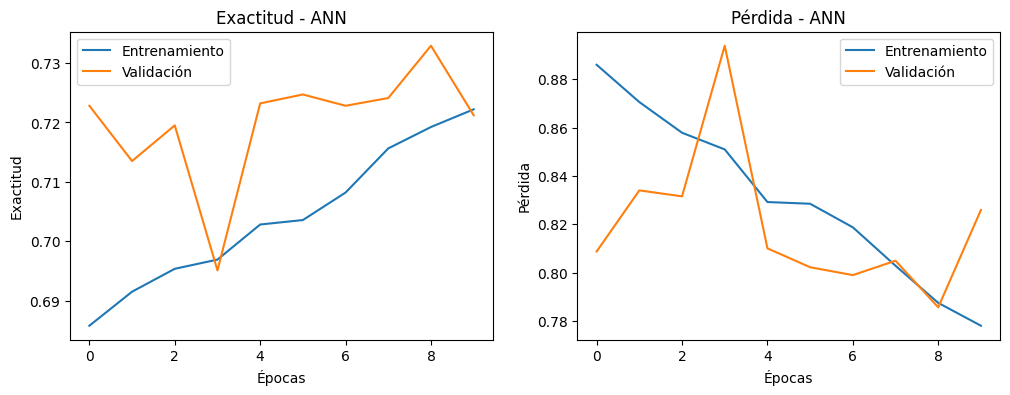

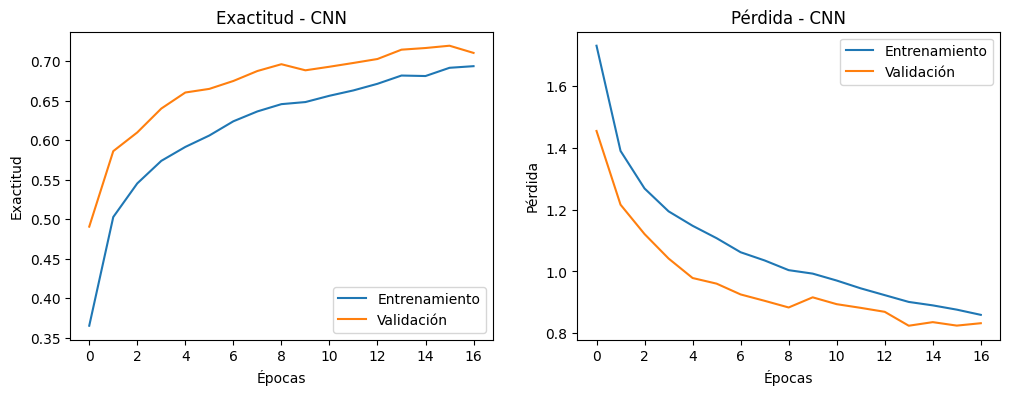

In [ ]:
def plot_history(history, title="Modelo"):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Exactitud - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Exactitud')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

# Graficar ANN
plot_history(history_ann, "ANN")

# Graficar CNN
plot_history(history_cnn, "CNN")

### Matriz de confusión y ejemplos de predicciones erróneas.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo CNN
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generar matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matriz de Confusión - CNN')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Encontrar índices de predicciones erróneas
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

# Mostrar 12 ejemplos de predicciones erróneas
num_errors_to_show = min(12, len(incorrect_indices))
plt.figure(figsize=(12, 8))

for i in range(num_errors_to_show):
    idx = incorrect_indices[i]
    
    plt.subplot(3, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Mostrar la imagen
    plt.imshow(x_test[idx])
    
    # Etiqueta real vs predicción
    real_label = class_names[y_true_classes[idx]]
    pred_label = class_names[y_pred_classes[idx]]
    confidence = np.max(y_pred[idx]) * 100
    
    # Título con información de la predicción
    plt.title(f"Real: {real_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", 
              fontsize=10)

plt.suptitle('Ejemplos de Predicciones Erróneas', fontsize=14)
plt.tight_layout()
plt.show()
